# National Water Model pull and plot
*J. Michelle Hu  
University of Utah  
July 2024*  
---

Acquisition code pulled from https://github.com/CIROH-UVM/training-data-workflows-101/blob/main/05-ExpandingTheWorkflow_Acquire.ipynb

In [40]:
from s3fs import S3FileSystem, S3Map
import xarray as xr
import pyproj
import geopandas as gpd
import os
import numpy as np
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

In [41]:
# For the NWM env follow these instructions
# https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
pyprojdatadir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-hb784bbd_0/share/proj'
pyproj.datadir.set_data_dir(pyprojdatadir)

## Load SNOTEL site location data
Add in the snotel location code here so there's no need to read/write to file  
TODO: Need to keep site_name associated with extracted ds for plotting and in metadata of extracted DS

In [42]:
site_gdf = gpd.read_file('/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/yampa_sites.json')
site_gdf

,ntwk,state,site_name,ts,start,lat,lon,elev,county,huc,site_num,geometry
0,SNTL,CO,Bear River (1061),None,2004-October,40.06,-107.01,9112,Routt,Yamcolo Reservoir-Bear River (140500010102),1061,POINT (328571.15744 4436352.34706)
1,SNTL,CO,Buffalo Park (913),None,1995-September,40.23,-106.60,9249,Grand,Deer Creek-Red Dirt Creek (140100010706),913,POINT (363880.83767 4454513.15666)
2,SNTL,CO,Crosho (426),None,1985-October,40.17,-107.06,8973,Rio Blanco,Hunt Creek (140500010106),426,POINT (324589.43355 4448660.39629)
3,SNTL,CO,Dry Lake (457),None,1979-October,40.53,-106.78,8271,Routt,City of Steamboat Springs-Yampa River (1405000...,457,POINT (349237.12327 4488106.85307)
4,SNTL,CO,Elk River (467),None,1978-October,40.85,-106.97,8739,Routt,Steamboat Lake-Willow Creek (140500010206),467,POINT (333940.15398 4523973.53493)
5,SNTL,CO,Lost Dog (940),None,1998-August,40.82,-106.75,9327,Routt,Outlet North Fork Elk River (140500010203),940,POINT (352419.26997 4520249.18863)
6,SNTL,CO,Rabbit Ears (709),None,1985-October,40.37,-106.74,9411,Routt,Harrison Creek (140500010402),709,POINT (352275.16748 4470278.06683)
7,SNTL,CO,Ripple Creek (717),None,1985-October,40.11,-107.29,10350,Rio Blanco,Snell Creek-North Fork White River (140500050102),717,POINT (304831.3735 4442479.75675)
8,SNTL,CO,Tower (825),None,1978-October,40.54,-106.68,10620,Routt,Fish Creek (140500010407),825,POINT (357728.50153 4489050.68327)


## Write this to file for easy read-in later

In [43]:
# # Use WKT to get proj4 string
# # https://gis.stackexchange.com/questions/8547/what-is-the-best-way-to-programmatically-convert-between-wkt-and-proj4-string

# bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
# fs = S3FileSystem(anon=True)
# ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')
# from osgeo import osr
# srs = osr.SpatialReference()
# wkt_text = ds[var].attrs['esri_pe_string']
# print(wkt_text)

# srs.ImportFromWkt(wkt_text)
# srs.MorphFromESRI()
# print(f"WKT for use as .prj: {srs.ExportToWkt()}")
# print(f"Equivalent proj4 string: {srs.ExportToProj4()}")
# proj4 = srs.ExportToProj4()
# proj4

In [44]:
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"
# This is the correct one (derived from esri_pe_string)
# Don't use the proj4 string from the NWM ds.attrs['proj4'], it appears to be wrong
# proj4 = '+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'
# Write
with open(proj_fn, "w") as text_file:
    text_file.write(proj4)

# Read
with open(proj_fn, "r") as f:
    proj4 = f.read()
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [45]:
# Change the crs of the site_gdf to the NWM crs
site_gdf.set_crs('epsg:32613', inplace=True, allow_override=True)
site_gdf = site_gdf.to_crs(crs=proj4)
site_gdf.crs

<Projected CRS: +proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [46]:
%%time
yampa_nwm_ds = proc.get_nwm_retrospective_LDAS(site_gdf, start='2019-10-01', end='2020-09-30', var='SNOWH')

CPU times: user 2.01 s, sys: 84.6 ms, total: 2.1 s
Wall time: 7.28 s


In [47]:
import matplotlib.pyplot as plt

CPU times: user 3.63 s, sys: 2.41 s, total: 6.04 s
Wall time: 17.2 s


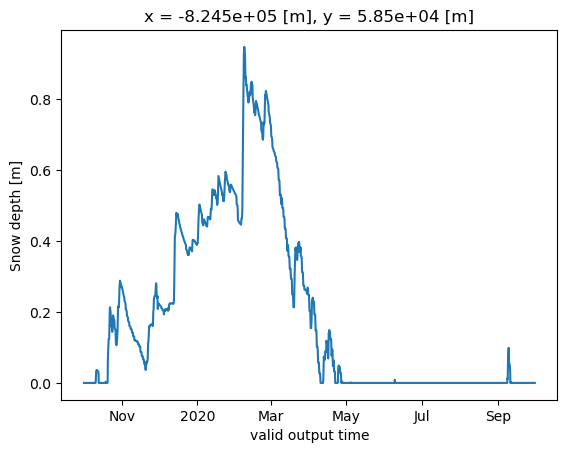

In [48]:
%%time
yampa_nwm_ds[0].plot()

CPU times: user 25.1 s, sys: 18.6 s, total: 43.7 s
Wall time: 2min 14s


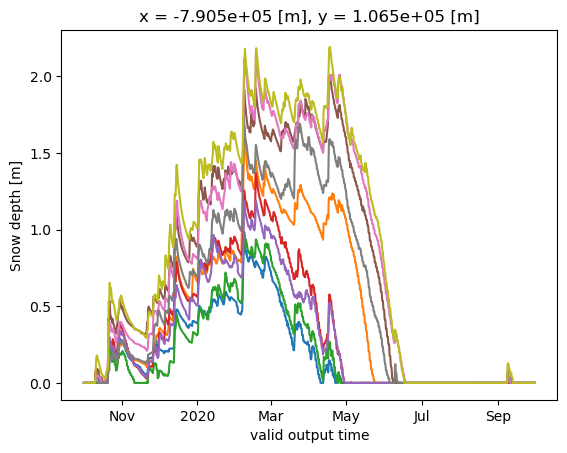

In [16]:
%%time
fig, ax = plt.subplots(1)
for ds in yampa_nwm_ds:
    ds.plot(ax=ax)

## Spatial: now do the same for the model domain

In [ ]:
# def get_nwm_retrospective_LDAS(site_gdf, start=None, end=None, var=None):
#     '''
#     '''
#     bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
#     fs = S3FileSystem(anon=True)
#     ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')
    
#     if var is not None:
#         ds = ds[var]
      
#     # Extract data by each site location
#     ds_list = [np.squeeze(ds.sel(x=x, y=y, method='nearest')) for x, y in zip(site_gdf.geometry.x.values, site_gdf.geometry.y.values)]

#     if start is not None and end is not None:
#         ds_list = [ds.sel(time=slice(f'{start}T00:00:00', f'{end}T23:00:00')) for ds in ds_list]
    
#     return ds_list

In [23]:
bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
fs = S3FileSystem(anon=True)
ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')

In [25]:
ds

<xarray.Dataset> Size: 510TB
Dimensions:   (time: 128568, y: 3840, x: 4608, vis_nir: 2, soil_layers_stag: 4)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
  * x         (x) float64 37kB -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 31kB -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Dimensions without coordinates: vis_nir, soil_layers_stag
Data variables: (12/21)
    ACCET     (time, y, x) float64 18TB ...
    ACSNOM    (time, y, x) float64 18TB ...
    ALBEDO    (time, y, x) float64 18TB ...
    ALBSND    (time, y, vis_nir, x) float64 36TB ...
    ALBSNI    (time, y, vis_nir, x) float64 36TB ...
    COSZ      (time, y, x) float64 18TB ...
    ...        ...
    SNOWH     (time, y, x) float64 18TB ...
    SOIL_M    (time, y, soil_layers_stag, x) float64 73TB ...
    SOIL_W    (time, y, soil_layers_stag, x) float64 73TB ...
    TRAD      (time, y, x) float64 18TB ...
    UGDRNOFF  (time, y, x) float64 18TB ...
    crs       |S1 1B ...
Attributes:
    Conventions:          CF-1.6
    GDAL_DataType:        Generic
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    history:              Thu Sep 28 08:10:06 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    model_output_type:    land
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [29]:
ds.attrs['proj4']

'+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@null +wktext  +no_defs'

In [30]:
proj4

'+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [49]:
type(ds)

xarray.core.dataset.Dataset

In [56]:
ds.x.min(), ds.x.max()

(<xarray.DataArray 'x' ()> Size: 8B
 array(-2303499.25),
 <xarray.DataArray 'x' ()> Size: 8B
 array(2303500.75))

In [66]:
# Define a bounding box by lat lon for the model domain in coordinates
#Upper Yampa  -107.707˚, 39.967˚, -106.663˚, 40.901˚
#Lower Yampa  -109.044˚, 40.105 ˚, -107.525˚, 40.772˚
# Lower Left, Lower Right, Upper Right, Upper Left, Lower Left to close the polygon
yampa_latlon = [(-109.044, 39.967), (-106.663, 39.967), (-106.663, 40.901), (-109.044, 40.901), (-109.044, 39.967)]
yampa_latlon

[(-109.044, 39.967),
 (-106.663, 39.967),
 (-106.663, 40.901),
 (-109.044, 40.901),
 (-109.044, 39.967)]

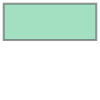

In [67]:
from shapely.geometry import Polygon
# Turn the lat lon box into a shapely polygon
yampa_poly = Polygon(yampa_latlon)
yampa_poly

In [69]:
# Turn the Polygon into a GeoDataFrame
yampa_gdf = gpd.GeoDataFrame(geometry=[yampa_poly])
yampa_gdf

,geometry
0,"POLYGON ((-109.044 39.967, -106.663 39.967, -1..."


In [70]:
# Change the crs of the site_gdf to the NWM crs
yampa_gdf.set_crs('epsg:4326', inplace=True, allow_override=True)
yampa_gdf = yampa_gdf.to_crs(crs=proj4)
yampa_gdf.crs

<Projected CRS: +proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [71]:
# Convert to the NWM proj4
yampa_nwmproj = yampa_gdf.to_crs(crs=proj4)

In [74]:
yampa_nwmproj.geometry

0    POLYGON ((-992046.414 71191.652, -796998.415 4...
Name: geometry, dtype: geometry

In [78]:
yampa_nwmproj.bounds

,minx,miny,maxx,maxy
0,-992046.41407,44589.902232,-784877.154736,170739.350031


In [76]:
# Crop the dataset to the yampa polygon extent
cropped_ds = ds.sel(x=slice(yampa_nwmproj.bounds.minx.values[0], yampa_nwmproj.bounds.maxx.values[0]), 
                    y=slice(yampa_nwmproj.bounds.miny.values[0], yampa_nwmproj.bounds.maxy.values[0]))
cropped_ds

<xarray.Dataset> Size: 751GB
Dimensions:   (time: 128568, y: 126, x: 207, vis_nir: 2, soil_layers_stag: 4)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
  * x         (x) float64 2kB -9.915e+05 -9.905e+05 ... -7.865e+05 -7.855e+05
  * y         (y) float64 1kB 4.55e+04 4.65e+04 4.75e+04 ... 1.695e+05 1.705e+05
Dimensions without coordinates: vis_nir, soil_layers_stag
Data variables: (12/21)
    ACCET     (time, y, x) float64 27GB ...
    ACSNOM    (time, y, x) float64 27GB ...
    ALBEDO    (time, y, x) float64 27GB ...
    ALBSND    (time, y, vis_nir, x) float64 54GB ...
    ALBSNI    (time, y, vis_nir, x) float64 54GB ...
    COSZ      (time, y, x) float64 27GB ...
    ...        ...
    SNOWH     (time, y, x) float64 27GB ...
    SOIL_M    (time, y, soil_layers_stag, x) float64 107GB ...
    SOIL_W    (time, y, soil_layers_stag, x) float64 107GB ...
    TRAD      (time, y, x) float64 27GB ...
    UGDRNOFF  (time, y, x) float64 27GB ...
    crs       |S1 1B ...
Attributes:
    Conventions:          CF-1.6
    GDAL_DataType:        Generic
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    history:              Thu Sep 28 08:10:06 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    model_output_type:    land
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [80]:
var = 'SNOWH'
print(cropped_ds[var])
print(f'Variable size: {cropped_ds[var].nbytes/1e9:.1f} GB')

<xarray.DataArray 'SNOWH' (time: 128568, y: 126, x: 207)> Size: 27GB
[3353310576 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
  * x        (x) float64 2kB -9.915e+05 -9.905e+05 ... -7.865e+05 -7.855e+05
  * y        (y) float64 1kB 4.55e+04 4.65e+04 4.75e+04 ... 1.695e+05 1.705e+05
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]
Variable size: 26.8 GB


In [83]:
cropped_ds[var].time

<xarray.DataArray 'time' (time: 128568)> Size: 1MB
array(['1979-02-01T03:00:00.000000000', '1979-02-01T06:00:00.000000000',
       '1979-02-01T09:00:00.000000000', ..., '2023-01-31T18:00:00.000000000',
       '2023-01-31T21:00:00.000000000', '2023-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1MB 1979-02-01T03:00:00 ... 2023-02-01
Attributes:
    long_name:      valid output time
    standard_name:  time
    valid_max:      4863060
    valid_min:      4778100

In [95]:
# Based on validation timesteps, select a time slice
dt = '2020-02-14'

In [98]:
# convert to datetime object
dt = np.datetime64(dt)

In [99]:
cropped_ds[var].sel(time=dt)

<xarray.DataArray 'SNOWH' (y: 126, x: 207)> Size: 209kB
[26082 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 8B 2020-02-14
  * x        (x) float64 2kB -9.915e+05 -9.905e+05 ... -7.865e+05 -7.855e+05
  * y        (y) float64 1kB 4.55e+04 4.65e+04 4.75e+04 ... 1.695e+05 1.705e+05
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    grid_mapping:    crs
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]

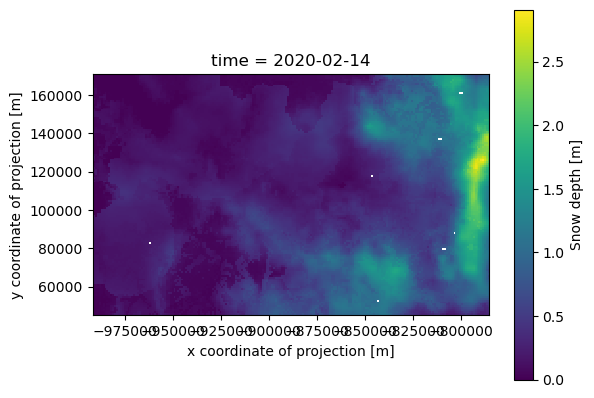

In [100]:
# Plot the snow depth as an image, select a time slice
fig, ax = plt.subplots()
cropped_ds[var].sel(time=dt).plot.imshow(ax=ax)
ax.set_aspect('equal')

In [122]:
''.join(str(dt).split('-'))

'20200214'

In [124]:
# find isnobal output and compare directly
snobal_dir = f"/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal/wy2020/yampa_basin_100m/run{''.join(str(dt).split('-'))}"

In [127]:
# Read in snow depth and plot
depth_fn = proc.fn_list(snobal_dir, "*snow.nc")[0]
depth_fn

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal/wy2020/yampa_basin_100m/run20200214/snow.nc'

In [163]:
depth = np.squeeze(xr.open_mfdataset(depth_fn, decode_coords="all")['thickness'])
depth.rio.write_crs('epsg:32613', inplace=True)
depth

<xarray.DataArray 'thickness' (y: 1043, x: 2086)> Size: 9MB
dask.array<getitem, shape=(1043, 2086), dtype=float32, chunksize=(1043, 2086), chunktype=numpy.ndarray>
Coordinates:
    time        datetime64[ns] 8B 2020-02-14T22:00:00.002244608
  * y           (y) float32 4kB 4.53e+06 4.53e+06 ... 4.426e+06 4.426e+06
  * x           (x) float32 8kB 1.568e+05 1.569e+05 ... 3.652e+05 3.653e+05
    projection  int64 8B 0
Attributes:
    units:        m
    description:  Predicted thickness of the snowcover

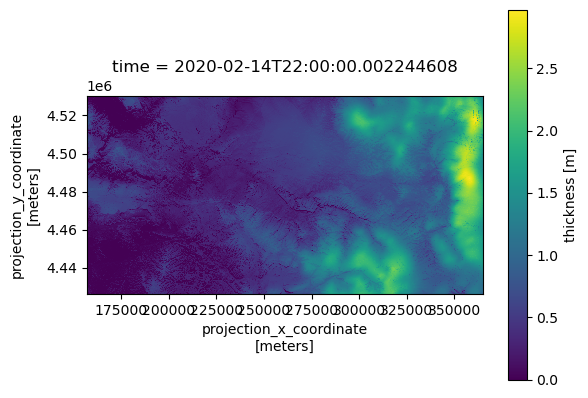

In [134]:
# Plot the iSnobal snow depth 
fig, ax = plt.subplots()
depth.plot.imshow(ax=ax)
ax.set_aspect('equal')

In [164]:
depth.shape

(1043, 2086)

In [165]:
nwm_depth = cropped_ds[var].sel(time=dt)
nwm_depth.shape

(126, 207)

In [173]:
nwm_depth.rio.write_crs(input_crs=proj4, inplace=True)

<xarray.DataArray 'SNOWH' (y: 126, x: 207)> Size: 209kB
[26082 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 8B 2020-02-14
  * x        (x) float64 2kB -9.915e+05 -9.905e+05 ... -7.865e+05 -7.855e+05
  * y        (y) float64 1kB 4.55e+04 4.65e+04 4.75e+04 ... 1.695e+05 1.705e+05
    crs      int64 8B 0
Attributes:
    esri_pe_string:  PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_Sphere",DAT...
    long_name:       Snow depth
    units:           m
    valid_range:     [0, 1000000]

In [174]:
# Warp to the same extent and projection
depth_reproj = depth.rio.reproject_match(nwm_depth)
depth_reproj.rio.crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-97],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [175]:
depth_reproj.shape

(126, 207)

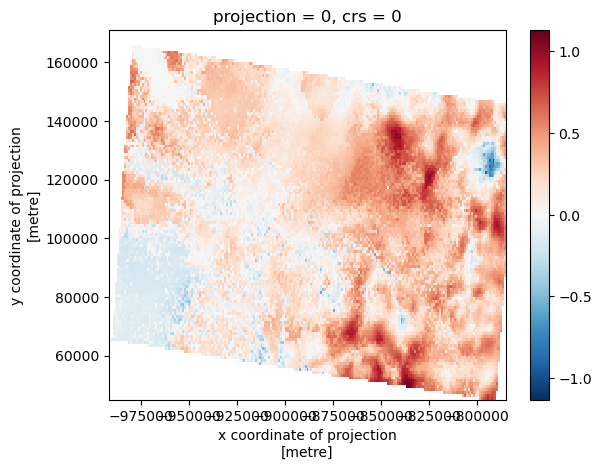

In [176]:
# Plot the difference
(depth_reproj - nwm_depth).plot.imshow(cmap='RdYlBu')